# GAN Using Keras and CIFAR10

# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD

2024-10-14 18:40:10.169617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 18:40:11.102054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-14 18:40:11.102147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-14 18:40:11.102154: W 

# Load Data

In [2]:
(X, y), (_, _) = tf.keras.datasets.cifar10.load_data()

# Selecting a single class of images
# The number was randomly chosen and any number
# between 1 and 10 can be chosen
X = X[y.flatten() == 8]

170498071/170498071 [==============================] - 2s 0us/step


# Define Parameters

In [3]:
# Defining the Input shape
image_shape = (32, 32, 3)
latent_dimensions = 100

# Generator Function

In [4]:
def build_generator():

        model = Sequential()

        # Building the input layer
        model.add(Dense(128 * 8 * 8, activation = "relu",
                        input_dim = latent_dimensions))
        model.add(Reshape((8, 8, 128)))
        model.add(UpSampling2D())        
        model.add(Conv2D(128, kernel_size = 3, padding = "same"))
        model.add(BatchNormalization(momentum = 0.78))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size = 3, padding = "same"))
        model.add(BatchNormalization(momentum = 0.78))
        model.add(Activation("relu"))
        model.add(Conv2D(3, kernel_size = 3, padding = "same"))
        model.add(Activation("tanh"))

        # Generating the output image
        noise = Input(shape = (latent_dimensions,))
        image = model(noise)

        return Model(noise, image)

# Discriminator Function

In [5]:
def build_discriminator(): 

        # Building the convolutional layers
        # to classify whether an image is real or fake
        model = Sequential()
        model.add(Conv2D(32, kernel_size = 3, strides = 2,
                         input_shape = image_shape, padding = "same"))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = "same"))
        model.add(ZeroPadding2D(padding = ((0, 1),(0, 1))))
        model.add(BatchNormalization(momentum = 0.82))
        model.add(LeakyReLU(alpha = 0.25))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = "same"))
        model.add(BatchNormalization(momentum = 0.82))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size = 3, strides = 1, padding = "same"))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.25))
        model.add(Dropout(0.25))

        # Building the output layer
        model.add(Flatten())
        model.add(Dense(1, activation = 'sigmoid'))
        image = Input(shape = image_shape)
        validity = model(image)

        return Model(image, validity)

# Image Generator

In [6]:
def display_images():

        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, latent_dimensions))
        generated_images = generator.predict(noise)

        # Scaling the generated images
        generated_images = 0.5 * generated_images + 0.5
        fig, axs = plt.subplots(r, c)
        count = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_images[count, :, :,])
                axs[i,j].axis('off')
                count += 1

        plt.show()
        plt.close()

# Build GAN

In [7]:
# Building and compiling the discriminator
discriminator = build_discriminator()

discriminator.compile(
    loss = 'binary_crossentropy', 
    optimizer = Adam(0.0002, 0.5), 
    metrics = ['accuracy']
    ) 

# Making the discriminator untrainable
# so that the generator can learn from fixed gradient
discriminator.trainable = False

# Building the generator
generator = build_generator()

# Defining the input for the generator and generating the images
z = Input(shape = (latent_dimensions,))
image = generator(z)

# Checking the validity of the generated image
valid = discriminator(image)

# Defining the combined model of the generator and the discriminator
combined_network = Model(z, valid)
combined_network.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
    )

2024-10-14 18:40:16.392341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-10-14 18:40:16.392364: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-14 18:40:16.392382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-104e7b74-4307-4537-9235-5299b504c876): /proc/driver/nvidia/version does not exist
2024-10-14 18:40:16.392658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the a

# Train Network

1/1 [==============================] - 0s 120ms/step


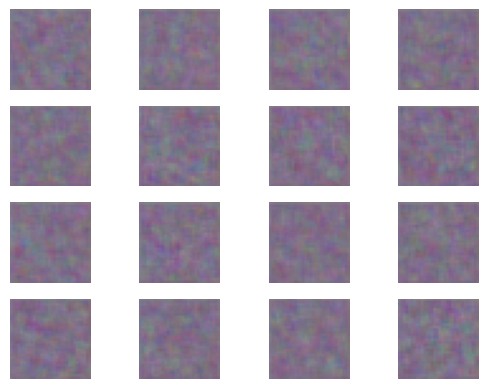

1/1 [==============================] - 0s 85ms/step


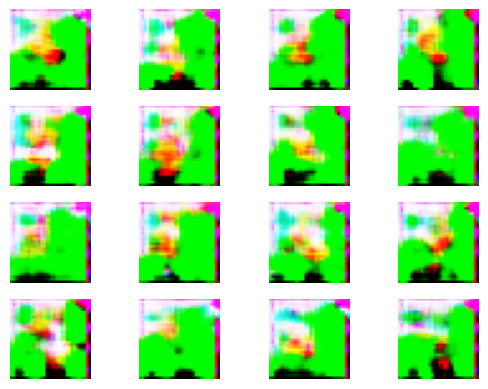

1/1 [==============================] - 0s 59ms/step


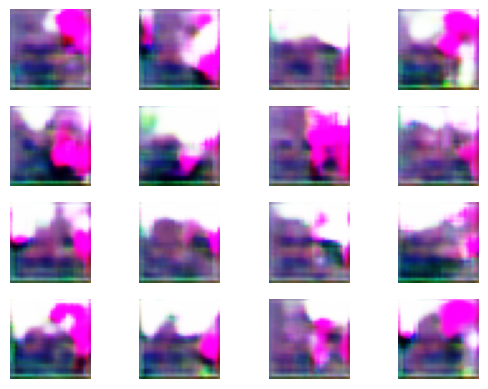

1/1 [==============================] - 0s 61ms/step


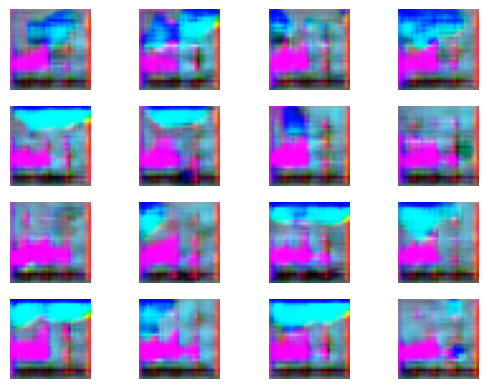

1/1 [==============================] - 0s 164ms/step


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [8]:
num_epochs = 15000
batch_size = 32
display_interval = 2500
losses = []

# Normalizing the input
X = (X / 127.5) - 1.

# Defining the Adversarial ground truths
valid = np.ones((batch_size, 1))

# Adding some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(num_epochs):

            # Training the Discriminator

            # Sampling a random half of images
            index = np.random.randint(0, X.shape[0], batch_size)
            images = X[index]

            # Sampling noise and generating a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
            generated_images = generator.predict(noise)

            # Training the discriminator to detect more accurately
            # whether a generated image is real or fake
            discm_loss_real = discriminator.train_on_batch(images, valid)
            discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

            # Training the generator

            # Training the generator to generate images
            # that pass the authenticity test
            genr_loss = combined_network.train_on_batch(noise, valid)

            # Tracking training progress                
            if epoch % display_interval == 0:
                 display_images()

In [ ]:
display_images()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=104e7b74-4307-4537-9235-5299b504c876' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>